In [40]:
import requests
from scipy.stats import norm
import numpy as np
from datetime import datetime, timedelta,timezone
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [43]:
#Lets read the historical_calls.csv file
df1 = pd.read_csv('historical_calls.csv')
df2 = pd.read_csv('historical_calls_2.csv')
df3 = pd.read_csv('historical_calls_3.csv')
df4 = pd.read_csv('test.csv')

In [44]:
#size of df2
print(df2.shape)
print(df1.shape)

(134861, 18)
(189210, 18)


In [45]:
#Lets merge the two dataframes
df = pd.concat([df1,df2])
df = pd.concat([df,df3])
df = pd.concat([df,df4])
#Lets remove duplicates rows
df = df.drop_duplicates()
print(df.shape)

(530424, 18)


When analyzing the implied volatility (IV) of an option, certain trades like combo trades, block trades, and liquidation events may indeed introduce distortions. Here's why each of these might not be ideal for IV analysis:

1. **Combo Trades**:
   - **Nature of Combo Trades**: These involve multiple positions executed simultaneously, often as part of complex strategies. The implied volatility derived from combo trades might not reflect the true market IV of a single option since the IV could be influenced by the combined risk and payoff structure of the strategy.
   - **Impact on IV Analysis**: Including combo trades can skew the IV analysis as these trades might reflect the overall strategy rather than the market's view on a single option's volatility.

2. **Block Trades**:
   - **Nature of Block Trades**: These large trades are often negotiated privately and may be executed at prices different from those prevailing in the public market. Block trades can reflect liquidity needs or strategic positions of large institutional investors rather than typical market conditions.
   - **Impact on IV Analysis**: Since block trades might not occur at market prices and can include a premium for liquidity, they might distort the actual implied volatility seen in the broader market.

3. **Liquidation Events**:
   - **Nature of Liquidation Events**: These occur when positions are forcibly closed, often during adverse market conditions or margin calls. Liquidation prices might be more reflective of urgent selling or buying pressures rather than balanced market sentiment.
   - **Impact on IV Analysis**: Implied volatility derived from liquidation trades can be anomalously high or low, as these trades are driven by necessity rather than a balanced view of market volatility.

### Best Practices for IV Analysis
To get a more accurate representation of the implied volatility, it is generally advisable to:

1. **Filter Out Specific Trades**: Exclude trades marked as combo trades, block trades, and liquidation events from your IV analysis to avoid distortions.
2. **Use Standard Trades**: Focus on standard buy and sell trades in the public order book, which more accurately reflect the market's consensus on volatility.
3. **Analyze Volume and Frequency**: Ensure that the trades you analyze are sufficiently frequent and of typical size to represent the market accurately.
4. **Check Market Conditions**: Be aware of overall market conditions during the period of your analysis, as extreme market conditions can also distort IV.


In [46]:
#Lets filter out options where there is a value on combo_id block_trade_id, and liquidation
df = df[(df['combo_id'].isnull()) & (df['block_trade_id'].isnull()) & (df['liquidation'].isnull())]
df.shape

(522131, 18)

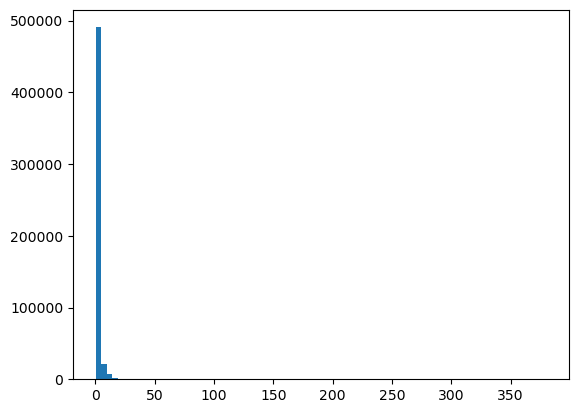

In [47]:
#Lets plot an hist of contracts and amount
plt.hist(df['amount'], bins=80)
plt.show()

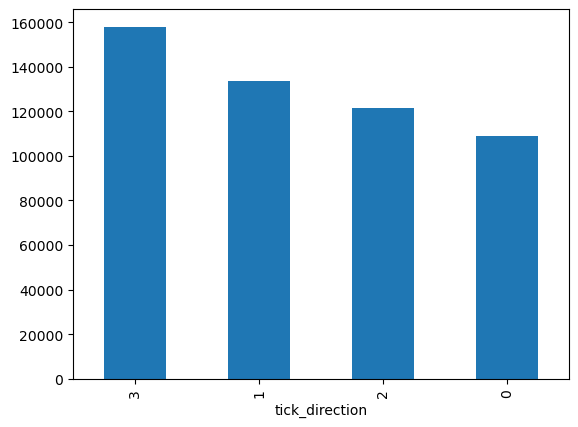

In [48]:
#Lets plot the tick_direction
df['tick_direction'].value_counts().plot(kind='bar')
plt.show()

The possible values for the `tick_direction` column are:

- **0**: Indicates that the trade price is equal to the previous trade price.
- **1**: Indicates an uptick, where the trade price is higher than the previous trade price.
- **2**: Indicates a downtick, where the trade price is lower than the previous trade price.
- **3**: Indicates a repeated tick, where the direction is the same as the previous tick.

These values provide information about the direction of the price change at the time of each trade. While useful for context, they may not directly impact IV analysis but can provide additional insights into market conditions.

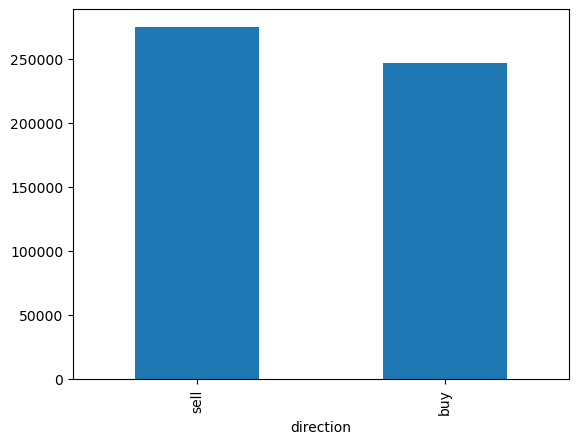

In [49]:
#Lets also plot the direction
df['direction'].value_counts().plot(kind='bar')
plt.show()

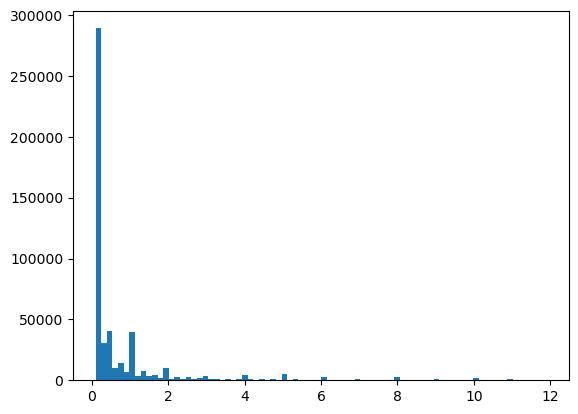

In [50]:
#Lets delete the rows with outliers quantity of contracts
df = df[df['amount'] < np.percentile(df['amount'], 99)]
plt.hist(df['amount'], bins=80)
plt.show()

While useful for understanding trade volume, extremely high or low contract numbers might reflect special conditions. Ensure average volume for better representation.

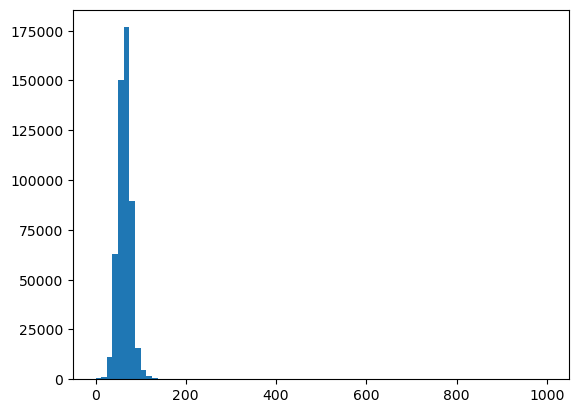

In [51]:
#Lets hist plot IV
plt.hist(df['iv'], bins=80)
plt.show()

In [52]:
#Lets drop IV who is 0 or bigger than 300
df = df[(df['iv'] > 0) & (df['iv'] < 300)] #Maybe i should drop anything below 150 as its not normal

In [53]:
df.shape 

(515713, 18)

In [54]:
#Lets create a date column, with day, month and year
df.loc[:,'date'] = pd.to_datetime(df['timestamp'])
#Now we modify date so it is only day, month and year
df.loc[:,'date'] = df['date'].dt.date
#Now create time to maturity
df.loc[:,'time_to_maturity'] = pd.to_datetime(df['maturity']) - pd.to_datetime(df['timestamp'])
#Now we create days to maturity
df.loc[:,'days_to_maturity'] = df['time_to_maturity'].dt.days
#we also create minutes to maturity
df.loc[:,'minutes_to_maturity'] = df['time_to_maturity'].dt.seconds/60 + df['days_to_maturity']*24*60
#Lets create time to maturity as a fraction of a year
df.loc[:,'time_to_maturity_year'] = df['minutes_to_maturity']/(365*24*60)
#Lets correct strike price
df.loc[:,'strike'] = df['strike']*10


In [55]:
df_grouped = df.groupby(['date','instrument_name']).count()
#Lets reset the index
df_grouped = df_grouped.reset_index()
#Lets rename the column
df_grouped = df_grouped.rename(columns = {'timestamp':'trades_per_day'})
#Lets select the columns we want
df_grouped = df_grouped[['date','instrument_name','trades_per_day']]


<Axes: xlabel='instrument_name'>

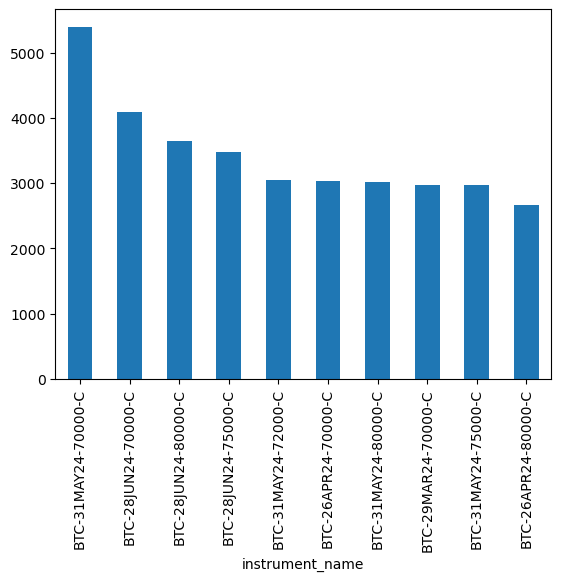

In [56]:
#Lets sum the trades_per_day by instrument_name

df_grouped_2 = df_grouped.groupby('instrument_name')['trades_per_day'].sum()
#Lets get the top 10 instruments
df_grouped_2 = df_grouped_2.sort_values(ascending=False)
df_grouped_2 = df_grouped_2.head(10)
#Lets plot the top 10 instruments
df_grouped_2.plot(kind='bar')

In [57]:
#Lets create a sub_df with the top 10 instruments, filtering df_grouped
sub_df = df_grouped[df_grouped['instrument_name'].isin(df_grouped_2.head(10).index)]

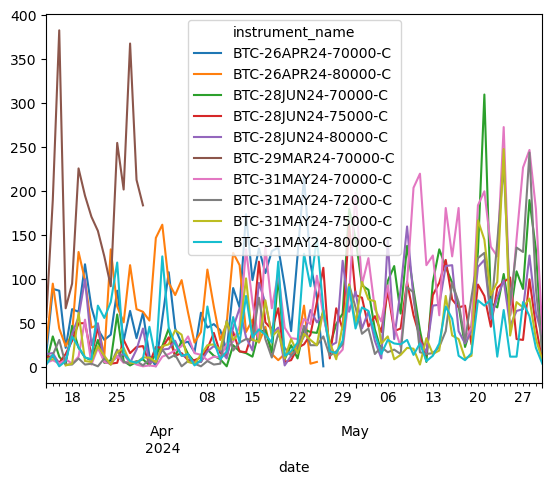

In [58]:
#Lets plot sub_df
sub_df = sub_df.pivot(index='date', columns='instrument_name', values='trades_per_day')
sub_df.plot(kind='line')
plt.show()

<Axes: xlabel='instrument_name'>

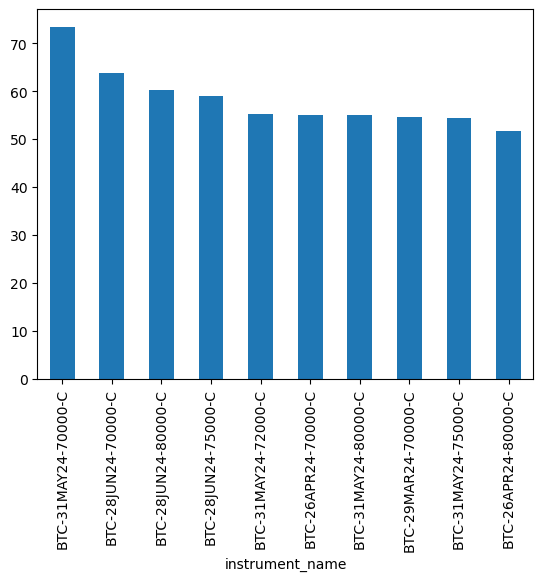

In [59]:
#Lets sum the trades_per_day by instrument_name

df_grouped_3 = df_grouped.groupby('instrument_name')['trades_per_day'].sum()
df_grouped_3 = np.sqrt(df_grouped_3)
#Lets get the top 10 instruments
df_grouped_3 = df_grouped_3.sort_values(ascending=False)
df_grouped_3 = df_grouped_3.head(10)
#Lets plot the top 10 instruments
df_grouped_3.plot(kind='bar')

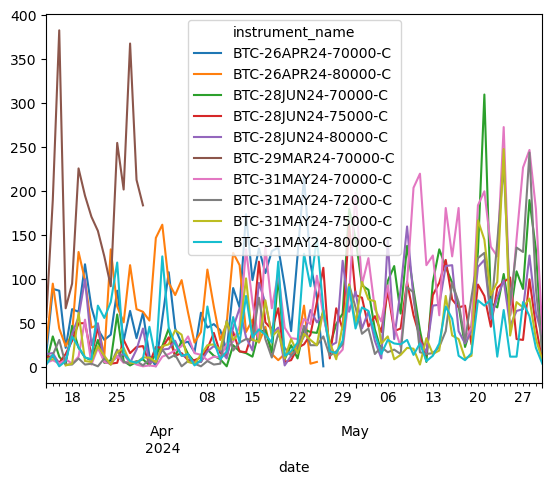

In [60]:
sub_df_2 = df_grouped[df_grouped['instrument_name'].isin(df_grouped_3.head(10).index)]
#plot
sub_df_2 = sub_df_2.pivot(index='date', columns='instrument_name', values='trades_per_day')
sub_df_2.plot(kind='line')
plt.show()

In [61]:
#Lets see wich instruments are in both df_grouped_2 and df_grouped_3
names = df_grouped_2.index.intersection(df_grouped_3.index)

In [62]:
#Lets create a sub sample of df with the instruments in names
df_sub = df[df['instrument_name'].isin(names)]


In [63]:
#Lets save to csv this sub sample
df_sub.to_csv('df_sub.csv', index=False)

In [64]:
#Lets now join the trades_per_day column to the original dataframe
df = pd.merge(df,df_grouped,how = 'left',on = ['date','instrument_name'])
df

,trade_seq,trade_id,timestamp,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,...,combo_trade_id,combo_id,block_trade_id,liquidation,date,time_to_maturity,days_to_maturity,minutes_to_maturity,time_to_maturity_year,trades_per_day
0,77,302653023,2024-05-22 22:55:45.846,0,0.0065,0.005848,44.05,BTC-23MAY24-69000-C,69087.14,buy,...,NaN,NaN,NaN,NaN,2024-05-22,0 days 01:04:14.154000,0,64.233333,0.000122,13
1,44,302652721,2024-05-22 22:51:37.832,3,0.0090,0.009152,50.91,BTC-25MAY24-70500-C,69111.15,sell,...,NaN,NaN,NaN,NaN,2024-05-22,2 days 01:08:22.168000,2,2948.366667,0.005610,44
2,118,302652590,2024-05-22 22:50:45.047,2,0.0615,0.061738,50.51,BTC-7JUN24-67000-C,69092.15,sell,...,NaN,NaN,NaN,NaN,2024-05-22,15 days 01:09:14.953000,15,21669.233333,0.041228,4
3,43,302652427,2024-05-22 22:48:59.512,2,0.0090,0.009200,50.72,BTC-25MAY24-70500-C,69115.78,sell,...,NaN,NaN,NaN,NaN,2024-05-22,2 days 01:11:00.488000,2,2951.000000,0.005615,44
4,553,302652368,2024-05-22 22:48:00.644,2,0.0635,0.063600,65.90,BTC-27SEP24-95000-C,69124.00,buy,...,NaN,NaN,NaN,NaN,2024-05-22,127 days 01:11:59.356000,127,182951.983333,0.348082,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515708,393,303530533,2024-05-30 06:05:25.779,2,0.0305,0.030391,52.62,BTC-28JUN24-74000-C,68014.54,sell,...,NaN,NaN,NaN,NaN,2024-05-30,28 days 17:54:34.221000,28,41394.566667,0.078757,18
515709,1041,303530439,2024-05-30 06:04:55.413,3,0.0001,0.000006,121.76,BTC-31MAY24-81000-C,68049.47,buy,...,NaN,NaN,NaN,NaN,2024-05-30,0 days 17:55:04.587000,0,1075.066667,0.002045,4
515710,30,303530382,2024-05-30 06:03:17.056,2,0.0037,0.003958,42.78,BTC-1JUN24-70000-C,68059.15,sell,...,NaN,NaN,NaN,NaN,2024-05-30,1 days 17:56:42.944000,1,2516.700000,0.004788,34
515711,41,303530348,2024-05-30 06:02:19.353,0,0.0055,0.005773,42.74,BTC-1JUN24-69500-C,68083.95,sell,...,NaN,NaN,NaN,NaN,2024-05-30,1 days 17:57:40.647000,1,2517.666667,0.004790,3


In [65]:
df_s = df.copy()

In [66]:
df = df_s.copy()
#Lets create the moneyness column
df.loc[:,'moneyness'] = df['index_price']/df['strike']
#Lets also create the hour of the day of the trade
df.loc[:,'hour'] = pd.to_datetime(df['timestamp']).dt.hour
#Lets also create the 7 days historical volatility of index_price
#If days_to_maturity is negative, we set it to 0
df.loc[:,'days_to_maturity'] = df['days_to_maturity'].apply(lambda x: max(0,x))
#Lets arrange df by timestamp

df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
#Lets set timestamp as index
df = df.set_index('timestamp')
df.loc[:,'historical_volatility'] = df['index_price'].rolling('7D').std() / df['index_price'].rolling('7D').mean()
#Lets also calculate the 7 days moving average of the index_price
df.loc[:,'moving_average'] = df['index_price']/df['index_price'].rolling('7D').mean()
#Now we do  the same for 3 and 1 days
df.loc[:,'historical_volatility_3'] = df['index_price'].rolling('3D').std() / df['index_price'].rolling('3D').mean()
df.loc[:,'moving_average_3'] = df['index_price']/df['index_price'].rolling('3D').mean()
df.loc[:,'historical_volatility_1'] = df['index_price'].rolling('1D').std() / df['index_price'].rolling('1D').mean()
df.loc[:,'moving_average_1'] = df['index_price']/df['index_price'].rolling('1D').mean()

In [67]:
#Where are NAs in df[['price', 'mark_price', 'index_price', 'strike', 'days_to_maturity', 'moneyness', 'historical_volatility']]
df[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','historical_volatility_3','moving_average_3','historical_volatility_1','moving_average_1']].isna().sum()

days_to_maturity           0
moneyness                  0
historical_volatility      1
hour                       0
moving_average             0
historical_volatility_3    1
moving_average_3           0
historical_volatility_1    1
moving_average_1           0
dtype: int64

In [68]:
df = df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['maturity'] = pd.to_datetime(df['maturity'])

# Find the first and last available dates in the data
first_date = df['timestamp'].min() 
#Lets add 2 days to first_date
first_date = first_date + timedelta(days=2)
last_date = df['timestamp'].max()

# Filter instruments whose maturity date is before the last date and start date is after the first date
filtered_instruments = df[(df['maturity'] < last_date) & (df['timestamp'] > first_date)]

# Count the number of trades for each instrument
trade_counts = filtered_instruments['instrument_name'].value_counts()

# Rank the instruments by the number of trades
ranked_instruments = trade_counts.reset_index()
ranked_instruments.columns = ['instrument_name', 'trade_count']
ranked_instruments = ranked_instruments.sort_values(by='trade_count', ascending=False)

# Display the ranked instruments
print(ranked_instruments.head())


       instrument_name  trade_count
0  BTC-26APR24-70000-C         2892
1  BTC-29MAR24-70000-C         2655
2  BTC-26APR24-80000-C         2544
3  BTC-24MAY24-70000-C         2302
4  BTC-26APR24-65000-C         2297


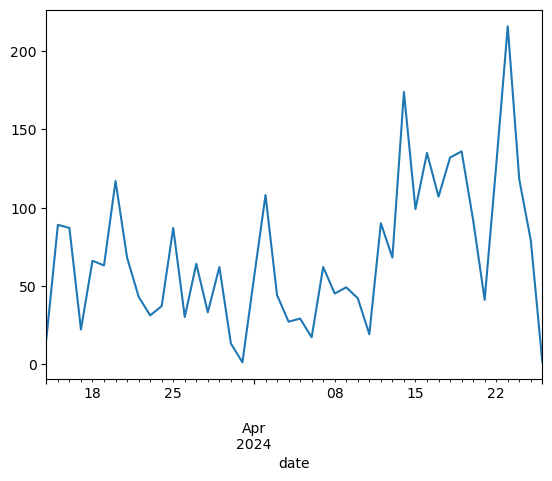

In [75]:
#Lets plot the number of trades per day of BTC-24MAY24-70000-C
#df sorter by date
df = df.sort_values('date')
df_btc = df[df['instrument_name'] == 'BTC-26APR24-70000-C']
df_btc = df_btc.groupby('date')['instrument_name'].count()
#The x axis is the date
df_btc.plot(kind='line')

plt.show()

In [73]:
#Lets get the strike price and maturity of BTC-26APR24-70000-C
df_btc = df[df['instrument_name'] == 'BTC-26APR24-70000-C']
df_btc = df_btc[['strike','maturity']]
df_btc = df_btc.drop_duplicates()
df_btc


,strike,maturity
3219,70000.0,2024-04-26


In [35]:
#Lets drop where rows of mark_price and historical_volatility are NAs
df = df.dropna(subset=['historical_volatility','historical_volatility_1'])

In [36]:
df.head()

,trade_seq,trade_id,tick_direction,price,mark_price,iv,instrument_name,index_price,direction,contracts,...,time_to_maturity_year,trades_per_day,moneyness,hour,historical_volatility,moving_average,historical_volatility_3,moving_average_3,historical_volatility_1,moving_average_1
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-14 04:00:13.870,768,290874613,1,0.0275,0.027118,81.55,BTC-26APR24-100000-C,73305.99,buy,0.1,...,0.117351,61,0.733060,4,0.000032,1.000022,0.000032,1.000022,0.000032,1.000022
2024-03-14 04:00:14.351,769,290874614,1,0.0275,0.027118,81.55,BTC-26APR24-100000-C,73305.99,buy,0.1,...,0.117351,61,0.733060,4,0.000026,1.000015,0.000026,1.000015,0.000026,1.000015
2024-03-14 04:02:04.053,2988,290874759,0,0.2895,0.289476,76.94,BTC-28JUN24-60000-C,73297.40,buy,0.1,...,0.289950,2,1.221623,4,0.000055,0.999923,0.000055,0.999923,0.000055,0.999923
2024-03-14 04:03:28.288,280,290874890,0,0.0016,0.001489,56.83,BTC-14MAR24-74000-C,73326.11,buy,0.2,...,-0.000463,80,0.990893,4,0.000149,1.000252,0.000149,1.000252,0.000149,1.000252
2024-03-14 04:03:28.290,281,290874891,0,0.0017,0.001489,58.37,BTC-14MAR24-74000-C,73326.11,sell,1.1,...,-0.000463,80,0.990893,4,0.000168,1.000210,0.000168,1.000210,0.000168,1.000210


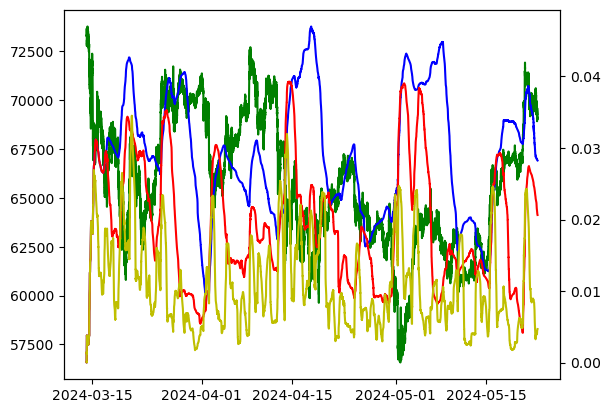

In [37]:
#Lets  plot the index_price and the historical_volatility, of 1, 3 and 7 days
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df['index_price'], 'g-')
ax2.plot(df['historical_volatility'], 'b-')
ax2.plot(df['historical_volatility_3'], 'r-')
ax2.plot(df['historical_volatility_1'], 'y-')

plt.show()


In [152]:
#Model for Implied Volatility
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Select relevant features and target variable
features = df[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','moving_average_3','moving_average_1','historical_volatility_3','historical_volatility_1']]
target = df['iv']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 8.502668294943119


In [ ]:
#Lets save the model 
import joblib
joblib.dump(model, 'model.pkl')


                   Feature  Importance
1                moneyness    0.302528
0         days_to_maturity    0.158405
4           moving_average    0.135046
2    historical_volatility    0.112773
7  historical_volatility_3    0.100823
8  historical_volatility_1    0.088286
3                     hour    0.041297
5         moving_average_3    0.036061
6         moving_average_1    0.024780


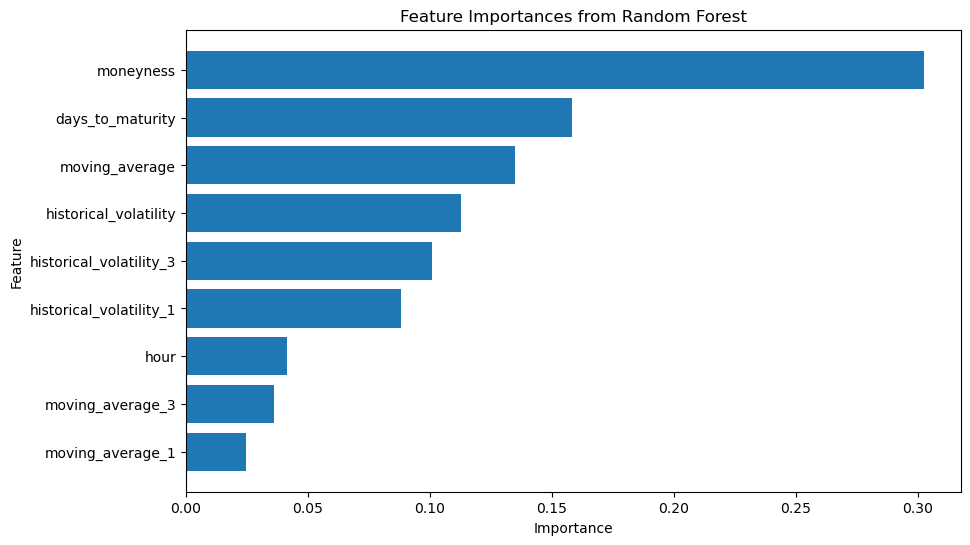

In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = features.columns

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top predictors
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()


In [345]:
#Lets take out the index and sort by timestamp
df = df.reset_index()
df = df.sort_values('timestamp')
#Lets predict and plot the IV
df.loc[:,'iv_pred'] = model.predict(features)
df[['iv', 'iv_pred']].plot(kind='line')
plt.show()

ValueError: Length of values (475123) does not match length of index (475192)

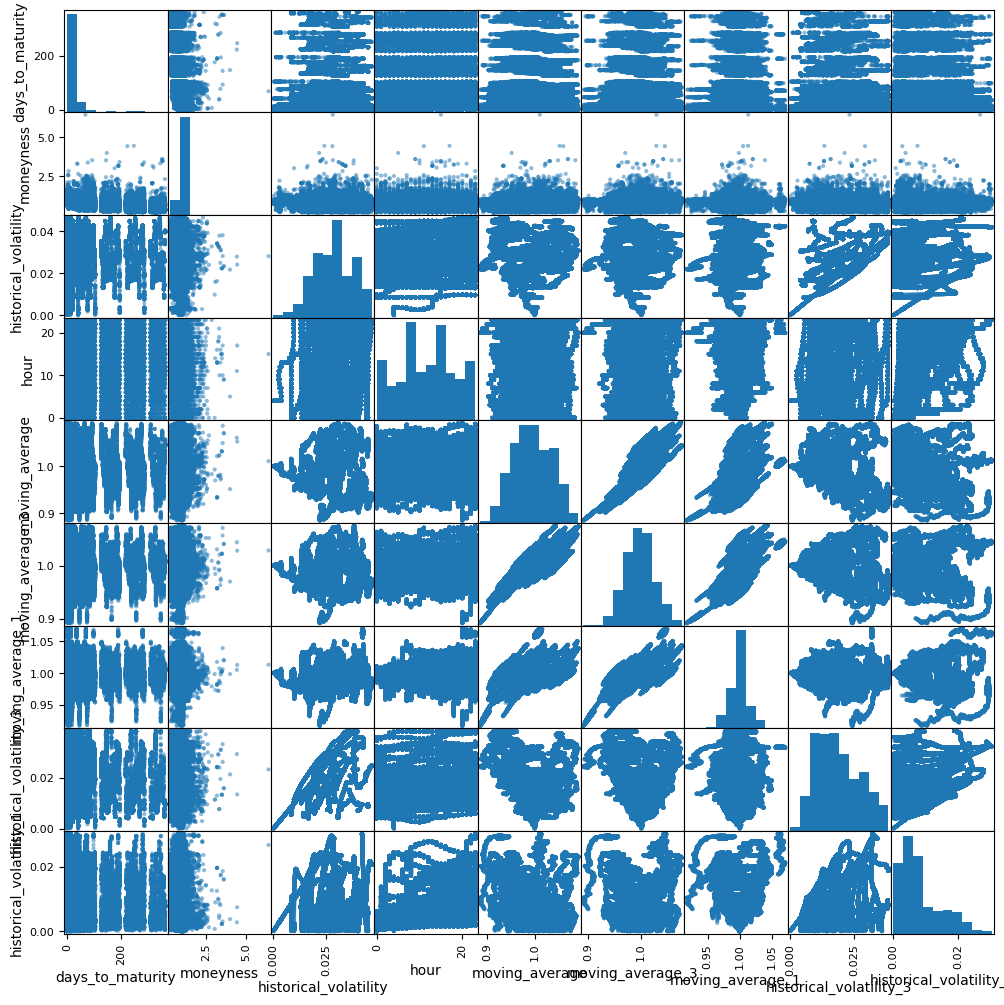

In [160]:
#Lets do a matrix plot for the freatures
pd.plotting.scatter_matrix(features, figsize=(12, 12))
plt.show()

In [360]:
#Lets now read the test csv
test = pd.read_csv('test.csv')

In [361]:
#Lets keep unique
test = test.drop_duplicates()
test.shape

(41421, 18)

In [362]:
#Lets first filter test
test = test[(test['combo_id'].isnull()) & (test['block_trade_id'].isnull()) & (test['liquidation'].isnull())]
test = test[(test['iv'] > 0) & (test['iv'] < 300)]
test = test[test['amount'] < np.percentile(test['amount'], 99)]

In [363]:

test = test.reset_index()
test.loc[:,'strike'] = test['strike']*10
test.loc[:,'moneyness'] = test['index_price']/test['strike']
test.loc[:,'hour'] = pd.to_datetime(test['timestamp']).dt.hour
test.loc[:,'days_to_maturity'] = pd.to_datetime(test['maturity']) - pd.to_datetime(test['timestamp'])
test.loc[:,'days_to_maturity'] = test['days_to_maturity'].dt.days
#If days to maturity is negative, we set it to 0
test.loc[:,'days_to_maturity'] = test['days_to_maturity'].apply(lambda x: max(0,x))
test.loc[:,'minutes_to_maturity'] = test['days_to_maturity']*24*60
test.loc[:,'time_to_maturity_year'] = test['minutes_to_maturity']/(365*24*60)
#Lets create date
test.loc[:,'date'] = pd.to_datetime(test['timestamp']).dt.date
test['timestamp'] = pd.to_datetime(test['timestamp'])

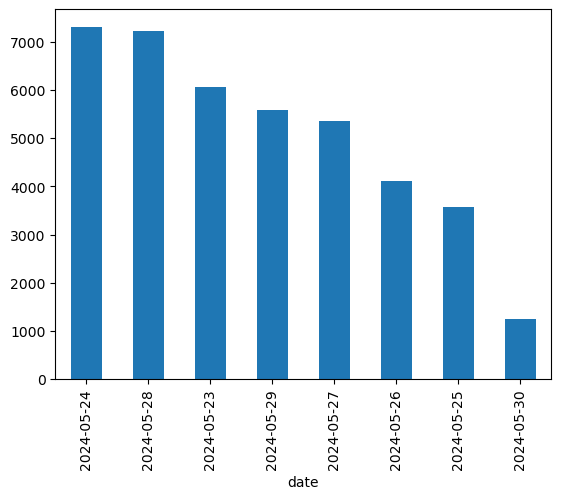

In [364]:
#Lets plot date
test['date'].value_counts().plot(kind='bar')
plt.show()

In [365]:
#Lets now test the model 
test.loc[:,'date'] = pd.to_datetime(test['date'])
test = test.sort_values('timestamp')
test = test.set_index('date')
test.loc[:,'historical_volatility'] = test['index_price'].rolling('7D').std() / test['index_price'].rolling('7D').mean()
test.loc[:,'moving_average'] = test['index_price']/test['index_price'].rolling('7D').mean()
test.loc[:,'historical_volatility_3'] = test['index_price'].rolling('3D').std() / test['index_price'].rolling('3D').mean()
test.loc[:,'moving_average_3'] = test['index_price']/test['index_price'].rolling('3D').mean()
test.loc[:,'historical_volatility_1'] = test['index_price'].rolling('1D').std() / test['index_price'].rolling('1D').mean()
test.loc[:,'moving_average_1'] = test['index_price']/test['index_price'].rolling('1D').mean()
test = test.dropna(subset=['historical_volatility','historical_volatility_1'])

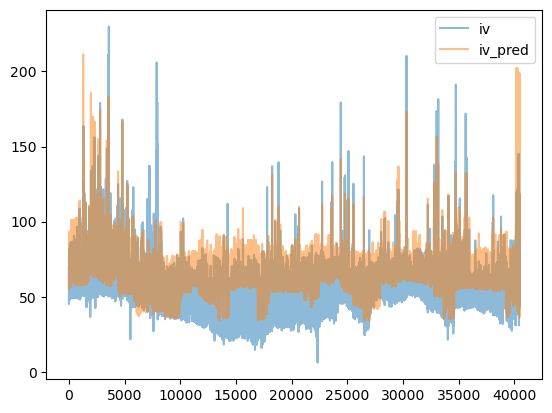

In [368]:
#Lets now test the model
test.loc[:,'iv_pred'] = model.predict(test[['days_to_maturity', 'moneyness', 'historical_volatility','hour','moving_average','moving_average_3','moving_average_1','historical_volatility_3','historical_volatility_1']])
test = test.reset_index()
test[['iv', 'iv_pred']].plot(kind='line',alpha=0.5)
plt.show()

In [367]:
#Lets get the mean squared error
mse = mean_squared_error(test['iv'], test['iv_pred'])
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 241.71415772884674


### Purpose
The Black-Scholes formula aims to provide a theoretical estimate of the price of European put and call options, excluding the effects of dividends paid during the option's life. It is based on the assumption that markets are efficient, which means that the option prices are predicted as if they have been corrected to reflect all known information.

### The Formula
The price of a call option (C) can be calculated using the formula:

\[ $C = S_0 \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)$ \]

where:
- \( S_0 \) is the current stock price
- \( K \) is the strike price of the option
- \( T \) is the time to expiration
- \( r \) is the risk-free rate
- \( N(d) \) is the cumulative distribution function of the standard normal distribution
- \( d_1 \) and \( d_2 \) are calculated as follows:
- \[ d_1 = $ \frac{\ln(\frac{S_0}{K}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}}] $
- \[ d_2 = $d_1 - \sigma \sqrt{T} $]
- \( $\sigma$ \) is the volatility of the stock's returns


- \($N(d_1)$\) and \($N(d_2)$\) are probabilities derived from the standard normal distribution, which help in calculating the expected benefit from owning the stock and the expected cost of exercising the option, respectively.
- \(N(d_1)\) gives the probability that the option will be in the money (profitable to exercise) by the expiration date, adjusted for the risk-free rate and the time remaining until expiration.
- \(N(d_2)\) adjusts this probability by the volatility of the stock, accounting for the likelihood that the stock's price will exceed the strike price at expiration.


### Key Assumptions
The Black-Scholes model is based on several critical assumptions:
1. **Stock prices follow a log-normal distribution** because of continuous compounding.
2. **No dividends are paid out** during the life of the option.
3. **Markets are efficient**, meaning that prices reflect all known information.
4. **No commissions** are charged in the buying or selling of the option.
5. **Interest rates remain constant and known** over the option's life.
6. **Volatility is constant** over the option's life.

### Limitations
While the Black-Scholes formula is pioneering and widely used, it has limitations:
- It does not consider the payment of dividends.
- It assumes volatility and interest rates are constant, which might not hold in real-world scenarios.
- The log-normal distribution of stock prices may not accurately describe actual stock price movements, especially those exhibiting jumps or fat tails.



## Deribit FEES
Options Trading:
- **Taker Fee**: 0.03% of the underlying asset.
- **Maker Fee**: 0.03% of the underlying asset.
- **Exercise Fee**: 0.015% of the underlying asset per contract.

In [79]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Define Black-Scholes delta calculation for a call option
def call_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


In [80]:

# Define Black-Scholes call option price
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


In [130]:

# Delta hedging function with transaction costs
def synthetic_delta_hedging(df, forecast_iv_column, initial_stock_price, r=0.01, trading_fee_rate=0.002, network_fee=0.0003):
    # Initialize portfolio and stock positions
    portfolio_value = 0
    cash_position = initial_stock_price  # Starting with cash equal to initial stock price
    stock_position = 0  # Starting with 1 stock
    
    results = []

    for index, row in df.iterrows():
        S = row['index_price']
        K = row['strike']
        T = row['days_to_maturity'] / 365  # Convert days to years
        date = row['date']
       
        sigma_actual = row['iv'] / 100  # Convert percentage to decimal
        if forecast_iv_column != 0:
            sigma_forecast = row[forecast_iv_column] / 100  # Convert percentage to decimal
        else:
            sigma_forecast = sigma_actual
        # Calculate forecasted delta
        delta_forecast = (call_delta(S, K, T, r, sigma_forecast))*(-1) #is negative because we are shorting the call
        
        # Calculate the number of stocks to buy/sell to adjust to the new delta
        delta_change = delta_forecast - stock_position
        transaction_cost = 0
        
        if delta_change != 0:
            # Calculate transaction cost: trading fee + network fee
            trading_fee = abs(delta_change) * S * trading_fee_rate
            transaction_cost = trading_fee + network_fee
            #transaction_cost = 0
            
            if abs(delta_change * S) > 0:
                # Update cash position considering transaction cost
                cash_position -= transaction_cost #we substract the transaction cost from the cash position
                
                # Adjust stock position to maintain delta neutrality
                cash_position -= delta_change * S #if delta_change is positive, we are buying stock, if negative we are selling stock.
                #If we buy stock, we substract the stock price from the cash position
                stock_position = delta_forecast #we set the stock position to the forecasted delta
                
        
        # Calculate actual option price using Black-Scholes
        #option_price_actual = black_scholes_call(S, K, T, r, sigma_actual)
        
        # Update portfolio value
        portfolio_value = stock_position * S + cash_position #portfolio value is the stock position times the stock price plus the cash position
        
        # Store results
        results.append({
            'timestamp': index,
            'date': date,
            'index_price': S,
            'strike': K,
            'days_to_maturity': row['days_to_maturity'],
            'forecast_iv': sigma_forecast,
            'actual_iv': sigma_actual,
            'forecast_delta': delta_forecast,
            'delta_change': delta_change,
            'transaction_cost': transaction_cost,
            'portfolio_value': portfolio_value,
            'stock_position': stock_position,
        })
    
    return pd.DataFrame(results)

# Example usage (Do not execute this block, it's just an example)
# df_doge['predicted_iv'] = iv_predictions  # Assuming iv_predictions is obtained from the model
# results = delta_hedging(df_doge, 'predicted_iv', initial_stock_price=100)
# print(results.head())


Espacio


In [97]:
#Having df now we calculate the delta of the option
#Lets calculate the delta of the option
def delta(S,K,T,r,sigma,option_type):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    if option_type == 'call':
        delta = norm.cdf(d1)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
    return delta

In [78]:
#Lets get the delta
df['delta'] = df.apply(lambda x: delta(x['index_price'],x['strike'],x['time_to_maturity_year'],0,x['iv']/100,'call'),axis = 1)

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_3707/3705755300.py:4: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_3707/3705755300.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))


In [82]:
#Lets create a data with only BTC-26APR24-70000-C
df_btc_2 = df[df['instrument_name'] == 'BTC-26APR24-70000-C']


In [131]:
#Lets do delta hedging with df_btc_2
#Lets calculate the initial_stock_price as the delta of the first row
initial_stock_price = df_btc_2['index_price'].iloc[0]
results = synthetic_delta_hedging(df_btc_2, 0, initial_stock_price=0)

/var/folders/tp/zh64fv6d1lx6rq42d6ymqtqw0000gn/T/ipykernel_3707/850695703.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


In [132]:
results

,timestamp,date,index_price,strike,days_to_maturity,forecast_iv,actual_iv,forecast_delta,delta_change,transaction_cost,portfolio_value,stock_position
0,3219,2024-03-14,72113.53,70000.0,42,0.7278,0.7278,-0.598161,-0.598161,86.271327,-86.271327,-0.598161
1,3221,2024-03-14,72204.99,70000.0,42,0.7272,0.7272,-0.600148,-0.001987,0.287208,-141.266355,-0.600148
2,3686,2024-03-14,71768.75,70000.0,42,0.7404,0.7404,-0.590766,0.009382,1.346961,119.195215,-0.590766
3,4894,2024-03-14,70617.81,70000.0,42,0.7331,0.7331,-0.565253,0.025513,3.603577,795.527832,-0.565253
4,5930,2024-03-14,69407.06,70000.0,42,0.7376,0.7376,-0.538122,0.027131,3.766513,1476.141937,-0.538122
...,...,...,...,...,...,...,...,...,...,...,...,...
3036,310199,2024-04-25,63463.67,70000.0,0,0.9041,0.9041,-0.000000,0.000000,0.000000,5259.502398,-0.000000
3037,310610,2024-04-25,64103.19,70000.0,0,0.8542,0.8542,-0.000000,0.000000,0.000000,5259.502398,-0.000000
3038,310612,2024-04-25,64096.55,70000.0,0,0.8547,0.8547,-0.000000,0.000000,0.000000,5259.502398,-0.000000
3039,311209,2024-04-25,64478.96,70000.0,0,0.9209,0.9209,-0.000000,0.000000,0.000000,5259.502398,-0.000000


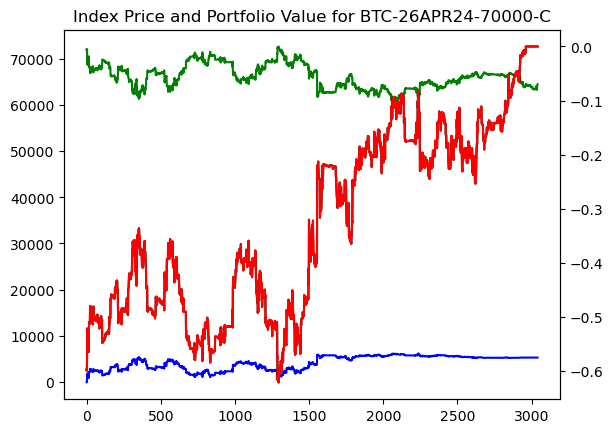

In [135]:
#Lets plo the index_price and portfolio_value
#on other index we plot the delta
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(results['index_price'], 'g-')
ax1.plot(results['portfolio_value'], 'b-')
#We also add the stock position
ax2.plot(results['stock_position'], 'black')
ax2.plot(results['forecast_delta'], 'r-')
#lets add a title
plt.title('Index Price and Portfolio Value for BTC-26APR24-70000-C')
plt.show()

In [119]:
#Lets get the last portfolio value
last_portfolio_value = results['portfolio_value'].iloc[-1]
print(f'Last Portfolio Value: {last_portfolio_value}')
#Lets also print the initial option value by black scholes
initial_option_value = black_scholes_call(df_btc_2['index_price'].iloc[0],df_btc_2['strike'].iloc[0],df_btc_2['time_to_maturity_year'].iloc[0],0,df_btc_2['iv'].iloc[0]/100)
print(f'Initial Option Value: {initial_option_value}')

Last Portfolio Value: 7252.881145606751
Initial Option Value: 8122.854696697264


In [ ]:
#We create a dataframe with date and the average of index_price, and also its std
df_BTC = df.groupby('date')['index_price'].agg(['mean','std'])
df_BTC = df_grouped.reset_index()
df_BTC = df_grouped.rename(columns = {'mean':'index_price_mean','std':'index_price_std'})
#We now calculate the delta of the option

In [53]:
df.columns

Index(['trade_seq', 'trade_id', 'timestamp', 'tick_direction', 'price',
       'mark_price', 'iv', 'instrument_name', 'index_price', 'direction',
       'contracts', 'amount', 'maturity', 'strike', 'combo_trade_id',
       'combo_id', 'block_trade_id', 'liquidation', 'date', 'time_to_maturity',
       'days_to_maturity', 'minutes_to_maturity', 'time_to_maturity_year',
       'trades_per_day'],
      dtype='object')

In [37]:
def black_scholes_call_delta(spot, strike, time_to_maturity, risk_free_rate, volatility): 
    if spot == 0 or time_to_maturity <= 0:  # Avoid divide by zero
        return 0
    d1 = (np.log(spot / strike) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    #d1 is the first part of the Black-Scholes formula.  
    #The formula is the division of the natural logarithm of the spot price divided by the strike price plus the sum of the risk-free rate and half of the volatility squared, multiplied by the time to maturity. This is then divided by the product of the volatility and the square root of the time to maturity.
    return norm.cdf(d1) #norm.cdf is the cumulative distribution function of the normal distribution.
#It returns the probability that a value is less than the z-score.

- "Moneyness" is a term used in options trading to describe the relationship between the strike price of an option and the current market price of the underlying asset. (in the money, at the money and out of the money)

In [38]:
def calculate_dynamic_volatility(spot, strike, time_to_maturity): 
    #designed to calculate a dynamic volatility for options pricing based on several factors including the spot price, strike price, and time to maturity
    base_vol = 0.52 # The baseline volatility if no other factors were at play.
    vol_increase_factor = 0.1  # A factor that determines how much the volatility increases with the moneyness of the option.
    min_volatility = 0.25  # The minimum possible value for the volatility, ensuring it doesn’t drop too low due to any adjustments.
    moneyness = abs(strike - spot) / spot  # Moneyness of the option. Moneyness measures how far the option is from being at the money (ATM).
    #This is the absolute difference between the strike price and the spot price divided by the spot price.
    
    # Calculate volatility adjustment based on moneyness
    #vol_adjustment = np.exp(vol_increase_factor * moneyness) - 1
    vol_adjustment = np.sin(vol_increase_factor * np.pi * moneyness) ** 2 #Pi radians equal 180 degrees. Thats half a circle (squared so is always possitive)
    #This is the percentaje.  The use of the sine function might be intended to create a periodic adjustment pattern, 
    #emphasizing higher volatility adjustments when moneyness increases, 
    #but stabilizing as moneyness continues to increase beyond certain points (due to the periodic nature of the sine function).
    #This will create a decreasing volatility adjustment as moneyness increases,
    # Time decay factor - adjust this for more realistic modeling
    #time_decay = 0.005 * time_to_maturity
    time_decay = np.log(1 + time_to_maturity) / (1 + time_to_maturity) ** 2  #Time maturity if a fraction less than 1, days percentage of a year
    #This calculates how volatility should decrease over time as the option approaches maturity. 
    # The formula uses a logarithmic decay that slows as maturity nears, 
    #reflecting that volatility typically decreases as less time remains for the underlying asset’s price to move significantly.
    adjusted_volatility = base_vol + vol_adjustment - time_decay 
    #base_vol is constant, vol_adjustment decreasing growth with moneyness adjustment, and time_decay is decreasing as time goes by.
    
    return max(adjusted_volatility, min_volatility)

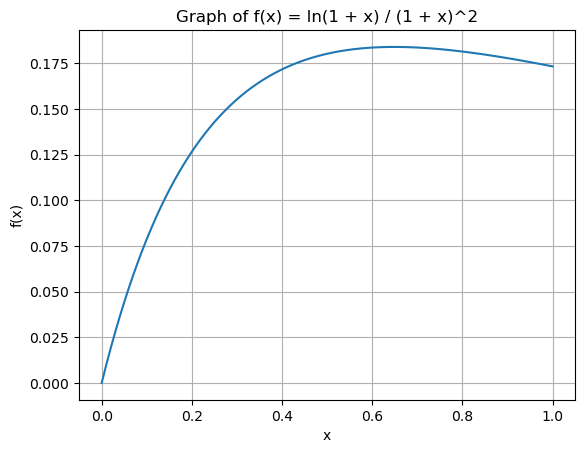

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def graph(formula, x_range):
    x = np.linspace(0, 1, num=1000)  # Generate 1000 points between 0 and 1
    y = formula(x)
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title("Graph of f(x) = ln(1 + x) / (1 + x)^2")
    plt.grid(True)
    plt.show()

# Example usage:
graph(lambda x: np.log(1 + x) / (1 + x)**2, range(0, 1))



In [40]:
def time_window(df, start_date, period):
    start_date = pd.to_datetime(start_date) #we convert the start_date to datetime
    end_date = start_date + pd.Timedelta(days=period) #we add the period to the start_date to get the end_date
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)] 
    #we filter the dataframe to only include the rows between the start_date and end_date
    df = df.sort_values(by='Date', ascending=True) #we sort the dataframe by the Date column
    df = df.reset_index(drop=True) #we reset the index of the dataframe

    df['price'] = df['Close'] #we create a new column called price which is the same as the Close column
    df['hourly_return'] = df['price'].pct_change().fillna(0.) #we calculate the hourly return of the price.
    #pct_change calculates the percentage change between the current and a prior element. fillna(0.) fills any missing values with 0
    df['approx_spread'] = df['High'] - df['Low'] #we calculate the approximate spread of the price in the hour
    return df



In [41]:
def hedge_model(df, risk_free_rate, period, strike_ratio, buffer, hedge_position, transaction_cost_bps):
    #simulate a dynamic hedging strategy for options using historical price data. 
    #adjustments to a hedging position over time based on the changing delta of a hypothetical option, 
    # incorporating transaction costs and monitoring net returns. 
    
    time_to_maturity = period / 365 #onverts the total period from days to years (since there are 365 days in a year). 
    transaction_cost = transaction_cost_bps / 10000 #converts the transaction cost from basis points to a decimal. 1 bps is 0.0001
    delta_underlying = 0 #initializes the delta of the underlying asset to 0.
    strike = df['price'].iloc[0] * (1+strike_ratio) #Sets the strike price based on the initial price in the DataFrame adjusted by the strike_ratio.
#Strike ratio is the ratio of the strike price to the spot price of the underlying asset.
    option_delta = np.array([])
    delta_adjustment = np.array([])
    #Main loop to iterate over each hour in the DataFrame
    for hours in range(len(df)):
        spot = df['price'].iloc[hours] #spot price is the close price at the current hour
        volatility = calculate_dynamic_volatility(spot, strike, time_to_maturity)
        #Computes the dynamic volatility for the option based on the current spot price, the strike, and time to maturity.
        
        delta = black_scholes_call_delta(spot, strike, time_to_maturity, risk_free_rate, volatility)
        #Uses the Black-Scholes model to calculate the delta of the option,
        # which measures the rate of change of the option price with respect to the price of the underlying asset.
        option_delta = np.append(option_delta, delta)

        spot_delta = delta * hedge_position #Calculates the portion of the delta to be hedged based on the hedge_position.
        #calculates the portion of the underlying asset required to maintain a neutral position, 
        #based on the current option delta and the size of the hedge position (how much of the position needs to be hedged).
        delta_diff = abs(spot_delta - delta_underlying) #Calculates the absolute difference between 
        #the current delta to hedge (spot_delta) and the previously hedged delta (delta_underlying).
        
        # Since we're removing bid-offer spread, no need to adjust the spot price here
        '''if delta_diff > buffer:
            if spot_delta > delta_underlying:
                adjustment = (spot_delta - delta_underlying) * spot * (1 + transaction_cost)
            else:
                adjustment = (spot_delta - delta_underlying) * spot * (1 - transaction_cost)
            
            delta_underlying += adjustment / spot'''

        if delta_diff > buffer: #Checks if the difference between the current and previous deltas exceeds the buffer.
            adjustment = spot_delta - delta_underlying #Calculates the adjustment needed to align the current delta with the previous delta.
            #Adjustment is basically the difference between the current delta and the previous delta.
            delta_underlying = spot_delta #Updates the previous delta to the current delta.
            #Delta underlying was 0 at the start, so the first adjustment will be the spot delta.
            
        elif delta_diff < buffer:
            adjustment = 0
        
        time_to_maturity -= 1 / (365 * 24) #Updates the time to maturity by subtracting the fraction of an hour from the total period.
        delta_adjustment = np.append(delta_adjustment, adjustment) #Appends the adjustment to the delta_adjustment array.

    #With the loop complete, we can update the DataFrame with the calculated deltas and adjustments.
    df['option_delta'] = option_delta #This are the hourly deltas of the option
    '''plt.plot(df['option_delta'])
    plt.title(f"Option Delta for month {df['Date'].iloc[0]}")
    plt.show()'''
    
    df['spot_delta'] = delta_adjustment.cumsum() #Calculates the cumulative sum of the delta adjustments and updates the spot_delta column.
    df['net_delta'] = df['spot_delta'] + df['option_delta'] #Calculates the net delta as the sum of the adjustments and the option deltas
    df['adjustment'] = delta_adjustment #Updates the adjustment column with the delta adjustments.
    df['action'] = np.where(df['adjustment'] < 0, 'sell', np.where(df['adjustment'] > 0, 'buy', 'hold'))
    #Defines an hourly 'action' column to track whether the hedging strategy should buy, sell, or hold based on the adjustments.
    #his process aims to minimize the risk associated with holding the option by adjusting the hedge to maintain a delta-neutral position, 
    # thus mitigating the impact of price movements on the option's value.
    # Since we're removing the bid-offer spread, adjust transaction costs directly without adjusting for bid-offer spread
    df['adjusted_price'] = df['price']  # Without considering the approximated bid-offer spread. simplifying transaction cost calculations.
    #Price was the close price, so we are not considering the spread in the close price.
    # Now, recalculate the spot return considering the adjusted price for transactions
    #df['spot_return'] = df['spot_delta'].shift(1) * df['adjusted_price'].diff() 
    df['spot_return'] = df['spot_delta'].shift(1) * df['adjusted_price'].shift(1) * df['hourly_return'] 
    #This is the return of the hedging strategy based on delta adjustments and the hourly return of the spot price (close).

    # Update transaction costs based on the action. Since there's no bid-offer spread, we don't adjust the price for transaction costs here
    df['transaction_costs'] = np.where(df['action'] != 'hold', 
                                    abs(df['adjustment']) * df['adjusted_price'] * transaction_cost, 
                                    0)  # No transaction cost for holds
    #Applies transaction costs based on hedging actions. Is the cost for the adjustment given the close price of the stock.
    # Recalculate the net spot return by subtracting transaction costs from the spot return
    df['net_spot_return'] = df['spot_return'] - df['transaction_costs']

    # Recalculate the cumulative return using the net returns
    df['cum_return'] = df['net_spot_return'].cumsum()
    '''plt.plot(df['cum_return'])
    plt.title(f"Cumulative trading return for month {df['Date'].iloc[0]}")
    plt.show()'''

    return df,strike
    


In [42]:
# Model Parameters
risk_free_rate = 0.01

period = 30
strike_raio = 0.1
buffer = 0.07
hedge_position = -1
transaction_cost_bps = 10



Executing a rolling window simulation to evaluate the performance of a dynamic hedging strategy using options over a specified time period (from January 1, 2022, to January 1, 2023). It calculates the total returns from the hedging strategy and the option payoff at the end of each period. 

In [226]:
# try a rolling window and recorde the return
#Set the initial and final dates of the simulation
start_date = pd.to_datetime('2022-01-01 00:00:00')
last_date = pd.to_datetime('2023-01-01 00:00:00')

total_money_return_list = []  #For storing the start date and total money return for each iteration

while start_date <= last_date: #Iterates monthly over the entire period
    #Period was 30 days, so we are iterating monthly
    df_time = time_window(df_all, start_date, period) #Extracts the data for the current month (30 days after start date)
    
    df, strike = hedge_model(df_time, risk_free_rate, period, strike_raio, buffer, hedge_position, transaction_cost_bps)
    #Applies the hedge_model function on the extracted data to simulate hedging over the specified time. 
    #It returns the modified DataFrame df and the strike price used for the options involved.
    
    #option payoff (end of period)
    end_price = df['price'].iloc[-1] #last price of the month
    option_payoff = max(0, end_price - strike*(1+risk_free_rate)**(-period/365))
    #Determines the payoff as the maximum of zero or the difference between the end price and the discounted strike price 
    # (taking into account the risk-free rate and the length of the period in days).

    total_money_return = option_payoff + df['cum_return'].iloc[-1]
    #Combines the option payoff with the cumulative return from the hedging strategy (cum_return from the DataFrame)
    # for the final calculation of total returns for the period.

    total_money_return_list.append((start_date, total_money_return)) #Stores the start date and total money return in the list.

    start_date = start_date + pd.DateOffset(months=1) #Moves to the next month for the next iteration.
    #print(start_date)
    print(option_payoff, df['cum_return'].iloc[-1])
    
result_df = pd.DataFrame(total_money_return_list, columns=['Start_Date', 'Total_Money_Return']) #Converts the list to a DataFrame.





0 1080.0781564871506
1836.643412627127 -272.72977264736926
0 696.2031451639692
0 989.4722501788311
0 1001.2355538983281
0 1000.753876190999
1440.6923747192523 -422.3560370106341
0 513.7119485943678
0 508.79466320865646
0 39.1043759977822
0 532.1884363156367
0 180.973057282571
4660.547325318534 -4255.411220743399


(array([18993., 19052., 19113., 19174., 19236., 19297., 19358.]),
 [Text(18993.0, 0, '2022-01'),
  Text(19052.0, 0, '2022-03'),
  Text(19113.0, 0, '2022-05'),
  Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01')])

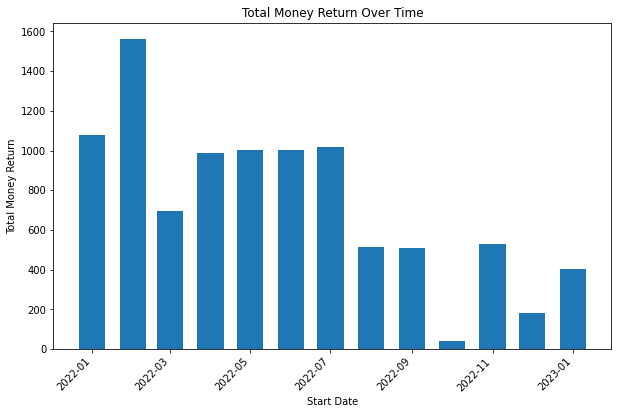

In [228]:
plt.figure(figsize=(10, 6))
plt.bar(result_df['Start_Date'], result_df['Total_Money_Return'], width=20) 
#Plots a bar chart of the total money return over time

# Add labels and title
plt.xlabel('Start Date')
plt.ylabel('Total Money Return')
plt.title('Total Money Return Over Time')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

In [230]:
# tune the buffer
buffer_list = np.arange(0,0.2,0.01)
risk_free_rate = 0.01
period = 30
strike_raio = 0.1
hedge_position = -1
transaction_cost_bps = 10

return_mean = [] 
for buffer in buffer_list:
    start_date = pd.to_datetime('2022-01-01 00:00:00')
    last_date = pd.to_datetime('2023-01-01 00:00:00')

    total_money_return_list = []
    while start_date <= last_date:
        df_time = time_window(df_all, start_date, period)
        
        df, strike = hedge_model(df_time, risk_free_rate, period, strike_raio, buffer, hedge_position, transaction_cost_bps)
        
        #option payoff
        end_price = df['price'].iloc[-1]
        option_payoff = max(0, end_price - strike*(1+risk_free_rate)**(-period/365))

        total_money_return = option_payoff + df['cum_return'].iloc[-1]

        total_money_return_list.append((start_date, total_money_return, strike))

        start_date = start_date + pd.DateOffset(months=1)
        #print(start_date)
        
    result_df_buffer = pd.DataFrame(total_money_return_list, columns=['Start_Date', 'Total_Money_Return','strike'])
    mean = (result_df_buffer['Total_Money_Return']/result_df_buffer['strike']).mean()
    return_mean.append({'buffer': buffer, 'pct_return_mean': mean})
# Convert results to a DataFrame for easier handling
return_mean = pd.DataFrame(return_mean)
return_mean_sort = return_mean.sort_values(by='pct_return_mean', ascending=False)



(0.015, 0.03)

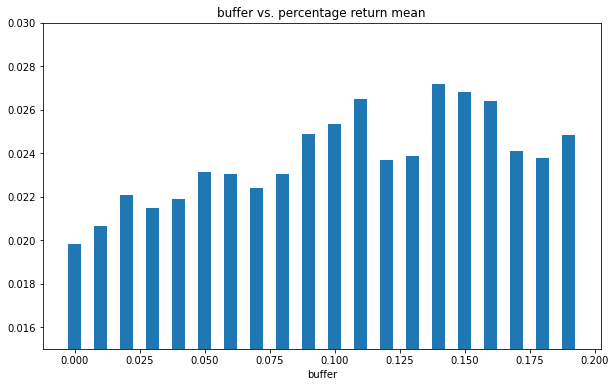

In [232]:
plt.figure(figsize=(10,6))
plt.title('buffer vs. percentage return mean')
plt.xlabel('buffer')

plt.bar(return_mean['buffer'],return_mean['pct_return_mean'], width = 0.005)
plt.ylim(0.015,0.03)

In [210]:
def black_scholes_call(S0, X, T, r, sigma):
    """
    Calculate the Black-Scholes call option price using dynamic volatility.
    
    Parameters:
    - S0: current price of the stock (underlying asset).
    - X: strike price of the option.
    - T: time to maturity of the option (in years).
    - r: risk-free interest rate.
    - sigma: volatility of the stock's returns (dynamic for each period).
    
    Returns:
    - Call option price (premium).
    """
    d1 = (np.log(S0 / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S0 * norm.cdf(d1)) - (X * np.exp(-r * T) * norm.cdf(d2))
    return call_price

In [233]:
start_date = pd.to_datetime('2022-01-01 00:00:00')
last_date = pd.to_datetime('2023-01-01 00:00:00')

call_option_price_list = []
while start_date <= last_date:

    df_time = time_window(df_all, start_date, period)
    
    current_price = df_time['price'].iloc[0]  # Current stock price
    strike_price = current_price * 1.1  # Strike price (10% above current price)
    time_to_maturity = 30/ 365# Time to maturity in years, assuming very short period
    risk_free_rate = 0.01 
    dynamic_volatility = 0.52
    volatility = calculate_dynamic_volatility(current_price, strike, time_to_maturity)
    print(volatility)
    call_option_price = black_scholes_call(current_price, strike_price, time_to_maturity, risk_free_rate, volatility)


    call_option_price_list.append((start_date, call_option_price, strike_price))
    start_date = start_date + pd.DateOffset(months=1)


    #print(start_date)
    
call_option_price_result = pd.DataFrame(call_option_price_list, columns=['Start_Date', 'call_option_price_list','strike_price'])

0.48886500329813476
0.4795911550500641
0.4856796843314285
0.4877522539841189
0.4787489981252777
0.4707480384255617
0.45362308999483514
0.45741621394327037
0.45342208787162586
0.452944503457821
0.453773224800453
0.45290354973713565
0.4535408348057359


In [234]:
call_option_price_result

,Start_Date,call_option_price_list,strike_price
0,2022-01-01,1021.636401,51321.743
1,2022-02-01,805.849632,42176.596
2,2022-03-01,940.636764,47916.000
3,2022-04-01,992.402362,50095.650
4,2022-05-01,788.946363,41448.737
5,2022-06-01,644.655672,35130.194
6,2022-07-01,377.422143,22324.588
7,2022-08-01,442.863421,25712.456
8,2022-09-01,372.762235,22070.873
9,2022-10-01,359.620665,21343.168


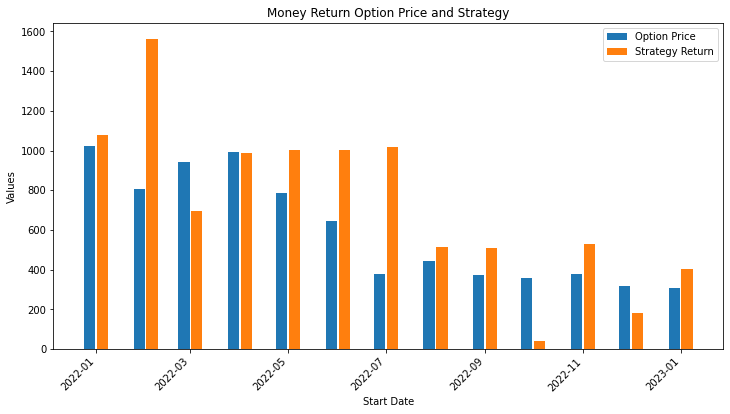

In [250]:
plt.figure(figsize=(12, 6))

# Plot the call option prices
plt.bar(call_option_price_result['Start_Date'] - pd.Timedelta(days=4), call_option_price_result['call_option_price_list'], width=7, label='Option Price')

# Plot the strategy returns with adjusted width and position
plt.bar(result_df['Start_Date'] + pd.Timedelta(days=4), result_df['Total_Money_Return'], width=7, label='Strategy Return')

# Add labels and title
plt.xlabel('Start Date')
plt.ylabel('Values')
plt.title('Money Return Option Price and Strategy')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()


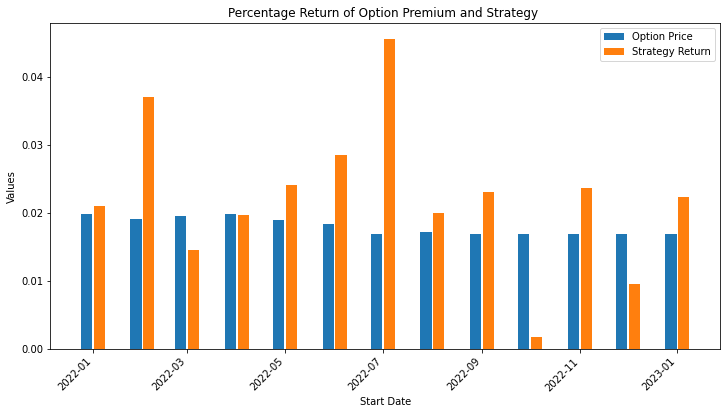

In [251]:
plt.figure(figsize=(12, 6))

# Plot the call option prices
plt.bar(call_option_price_result['Start_Date'] - pd.Timedelta(days=4), call_option_price_result['call_option_price_list']/call_option_price_result['strike_price'], width=7, label='Option Price')

# Plot the strategy returns with adjusted width and position
plt.bar(result_df['Start_Date'] + pd.Timedelta(days=4), result_df['Total_Money_Return']/call_option_price_result['strike_price'], width=7, label='Strategy Return')

# Add labels and title
plt.xlabel('Start Date')
plt.ylabel('Values')
plt.title('Percentage Return of Option Premium and Strategy ')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend()